## Importing Libraries used

In [1]:
!pip install -q torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 44.9 MB/s eta 0:00:00


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, Dict, List

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets

from timeit import default_timer as timer
from tqdm.auto import tqdm
from torchmetrics import Accuracy
from torch.utils.data import Subset

from sklearn.model_selection import train_test_split

import requests
import zipfile
from pathlib import Path
import random
from PIL import Image
from collections import Counter


## Downloading Dataset from GitHub

In [3]:
data_path = Path('data')
image_path = data_path/'dataset'
zip_image_path = data_path/'dataset.zip'

if image_path.is_dir():
  print(f'{image_path} already exist... \nSkipping download')
else:
  print(f'{image_path} not found, creating {image_path}')
  image_path.mkdir(parents=True, exist_ok=True)

  with open(zip_image_path, 'wb') as f:
    request = requests.get('https://github.com/maheshkrishnam/SOI_SDS_2024/raw/main/train_data_with_classes.zip')
    print('Downloading dataset')
    f.write(request.content)

  with zipfile.ZipFile(zip_image_path, 'r') as zip_ref:
    print('Unzipping dataset')
    zip_ref.extractall(image_path)


data/dataset not found, creating data/dataset
Unzipping dataset


## Understanding and Visualizing the dataset

### Understating the structure of dataset

In [4]:
def walk_through_dir(image_path):
  for dirpath, dirnames, filenames in os.walk(image_path):
    if len(filenames) == 0:
      print(f'{dirpath} have directories {dirnames}')
    elif len(dirnames) == 0:
      print(f'{dirpath} having {len(filenames)} files')
    else :
      print(f'{dirpath} have directories {dirnames} having {len(filenames)} files')



In [5]:
walk_through_dir(image_path=image_path)

data/dataset have directories ['crater', 'bright dune', 'swiss cheese', 'impact ejecta', 'dark dune', 'spider', 'other', 'slope streak']
data/dataset/crater having 1062 files
data/dataset/bright dune having 597 files
data/dataset/swiss cheese having 223 files
data/dataset/impact ejecta having 51 files
data/dataset/dark dune having 216 files
data/dataset/spider having 66 files
data/dataset/other having 3651 files
data/dataset/slope streak having 335 files


In [6]:
dataset_dir = image_path

dataset_dir

PosixPath('data/dataset')

### Visualizing images

#### Using PIL library

Image Class : other
Image shape : (227, 227) | Image width : 227 | Image height : 227
Image filename : /content/data/dataset/other/3730.jpg
Image : <PIL.JpegImagePlugin.JpegImageFile image mode=L size=227x227 at 0x7EDF4028EDA0>


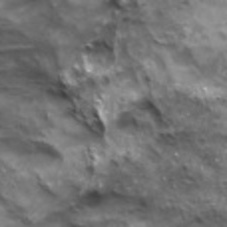

In [7]:
RANDOM_SEED = 0
random.seed(RANDOM_SEED)

pattern = '*/*.jpg'
image_path_list = list(image_path.glob(pattern))

random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem

img = Image.open(random_image_path)
print(f'Image Class : {image_class}')
print(f'Image shape : {img.size} | Image width : {img.width} | Image height : {img.height}')
print(f'Image filename : {img.filename}')
print(f'Image : {img}')
img


#### Using Matplot

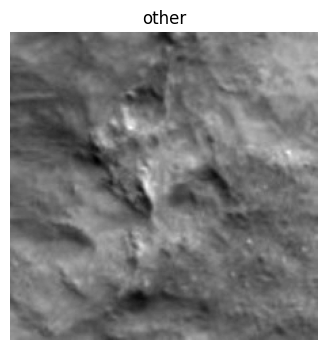

In [8]:
# preprocessing requires PIL library
plt.figure(figsize=(5,4))
plt.imshow(img, cmap='gray')
plt.title(image_class)
plt.axis('off')
plt.show()

## Loading dataset using ImageFolder

#### Creating transforms

In [9]:
transform = transforms.Compose([
    transforms.Resize(size=(28, 28)),
    transforms.ToTensor()
])

transform

Compose(
    Resize(size=(28, 28), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

In [10]:
whole_dataset = datasets.ImageFolder(
  root=dataset_dir,
  transform=transform,
  target_transform=None
)

whole_dataset

Dataset ImageFolder
    Number of datapoints: 6201
    Root location: data/dataset
    StandardTransform
Transform: Compose(
               Resize(size=(28, 28), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [11]:
whole_dataset[0]

(tensor([[[0.0000, 0.0039, 0.2745,  ..., 0.6588, 0.6510, 0.6314],
          [0.0000, 0.0039, 0.1529,  ..., 0.6588, 0.6392, 0.6549],
          [0.0000, 0.0000, 0.0706,  ..., 0.6510, 0.6471, 0.6510],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.6196, 0.6431, 0.6667],
          [0.0000, 0.0000, 0.0000,  ..., 0.6627, 0.6157, 0.6314],
          [0.0000, 0.0000, 0.0000,  ..., 0.6235, 0.5961, 0.6353]],
 
         [[0.0000, 0.0039, 0.2745,  ..., 0.6588, 0.6510, 0.6314],
          [0.0000, 0.0039, 0.1529,  ..., 0.6588, 0.6392, 0.6549],
          [0.0000, 0.0000, 0.0706,  ..., 0.6510, 0.6471, 0.6510],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.6196, 0.6431, 0.6667],
          [0.0000, 0.0000, 0.0000,  ..., 0.6627, 0.6157, 0.6314],
          [0.0000, 0.0000, 0.0000,  ..., 0.6235, 0.5961, 0.6353]],
 
         [[0.0000, 0.0039, 0.2745,  ..., 0.6588, 0.6510, 0.6314],
          [0.0000, 0.0039, 0.1529,  ..., 0.6588, 0.6392, 0.6549],
          [0.0000, 0.0000, 0.0706,  ...,

In [12]:
whole_dataset.class_to_idx

{'bright dune': 0,
 'crater': 1,
 'dark dune': 2,
 'impact ejecta': 3,
 'other': 4,
 'slope streak': 5,
 'spider': 6,
 'swiss cheese': 7}

In [13]:
train_dataset, val_dataset = train_test_split(whole_dataset, test_size=0.2, random_state=RANDOM_SEED)

len(train_dataset), len(val_dataset)

(4960, 1241)

Image shape : torch.Size([3, 28, 28])
Image datatype : torch.float32


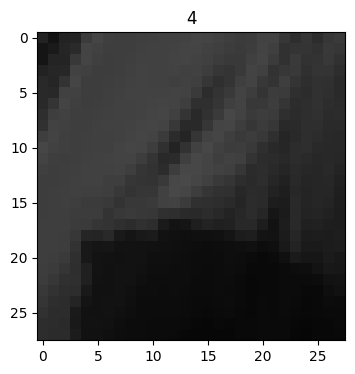

In [14]:
plt.figure(figsize=(5,4))
plt.imshow(train_dataset[0][0].permute(1,2,0))
plt.title(train_dataset[0][1])
print(f'Image shape : {train_dataset[0][0].shape}')
print(f'Image datatype : {train_dataset[0][0].dtype}')
plt.show()


#### Weight Assigning

In [47]:
all_labels = [label for _, label in whole_dataset]
class_counts = Counter(all_labels)

total_count = len(all_labels)
class_weights = {cls: total_count / count for cls, count in class_counts.items()}
print(class_counts, class_weights)

sample_weights = [class_weights[label] for _, label in train_dataset]
val_sample_weights = [class_weights[label] for _, label in val_dataset]

sample_weights = torch.tensor(sample_weights, dtype=torch.float)
val_sample_weights = torch.tensor(val_sample_weights, dtype=torch.float)

len(sample_weights), len(val_sample_weights), sample_weights, val_sample_weights

Counter({4: 3651, 1: 1062, 0: 597, 5: 335, 7: 223, 2: 216, 6: 66, 3: 51}) {0: 10.386934673366834, 1: 5.838983050847458, 2: 28.708333333333332, 3: 121.58823529411765, 4: 1.6984387838948234, 5: 18.51044776119403, 6: 93.95454545454545, 7: 27.807174887892376}


(4960,
 1241,
 tensor([1.6984, 1.6984, 1.6984,  ..., 5.8390, 1.6984, 1.6984]),
 tensor([10.3869,  1.6984,  1.6984,  ...,  1.6984,  1.6984,  1.6984]))

In [48]:
sampler = torch.utils.data.WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

val_sampler = torch.utils.data.WeightedRandomSampler(
    weights=val_sample_weights,
    num_samples=len(val_sample_weights),
    replacement=True
)

sampler, val_sampler

(<torch.utils.data.sampler.WeightedRandomSampler at 0x7ede474016c0>,
 <torch.utils.data.sampler.WeightedRandomSampler at 0x7ede47402830>)

#### Converting Dataset in DataLoader

In [49]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    sampler=sampler
)

val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    sampler=val_sampler
)


In [50]:
image, label = next(iter(train_dataloader))
image.shape, label.shape

(torch.Size([32, 3, 28, 28]), torch.Size([32]))

In [51]:
class Model(nn.Module):
  def __init__(self, input_shape, hidden_units, output_shape):
    super().__init__()
    self.block_1 = nn.Sequential(
      nn.Conv2d(in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
      nn.ReLU(),
      nn.BatchNorm2d(hidden_units),
      nn.Conv2d(in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2,
                  stride=1,
                   padding=1),
      nn.BatchNorm2d(hidden_units),
      nn.Dropout(0.4)
    )
    self.block_2 = nn.Sequential(
      nn.Conv2d(in_channels=hidden_units,
                out_channels=2*hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
      nn.ReLU(),
      nn.BatchNorm2d(2*hidden_units),
      nn.Conv2d(in_channels=2*hidden_units,
                out_channels=2*hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2,
                    stride=1,
                   padding=1),
      nn.BatchNorm2d(2*hidden_units),
      nn.Dropout(0.4)
    )
    self.block_3 = nn.Sequential(
      nn.Conv2d(in_channels=2*hidden_units,
                out_channels=3*hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
      nn.ReLU(),
      nn.BatchNorm2d(3*hidden_units),
      nn.Conv2d(in_channels=3*hidden_units,
                out_channels=3*hidden_units,
                kernel_size=3,
                stride=2,
                padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2,
                  stride=2,
                   padding=1),
      nn.BatchNorm2d(3*hidden_units),
      nn.Dropout(0.4)
    )
    self.classifier = nn.Sequential(
      nn.Flatten(),
      nn.Linear(in_features=3*hidden_units*8*8,
                out_features=output_shape),
      nn.Dropout(0.4),
      nn.Linear(in_features=output_shape,
                out_features=output_shape)
    )

  def forward(self, x: torch.Tensor):
    # print(x.shape)
    x = self.block_1(x)
    # print(x.shape)
    x = self.block_2(x)
    # print(x.shape)
    x = self.block_3(x)
    # print(x.shape)
    x = self.classifier(x)
    # print(x.shape)
    return x


In [52]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [53]:
model = Model(
    input_shape=3,
    hidden_units=64,
    output_shape=8
).to(device)

model

Model(
  (block_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=1, padding=1, dilation=1, ceil_mode=False)
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
  )
  (block_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=1, padding=1, dilation=1, ceil_mode=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7):

In [54]:
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(
    params=model.parameters(),
    lr=0.01,
    weight_decay=1e-4
)
accuracy_fn = Accuracy(task='multiclass', num_classes=8).to(device)

loss_fn, optimizer, accuracy_fn

(CrossEntropyLoss(),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.01
     maximize: False
     weight_decay: 0.0001
 ),
 MulticlassAccuracy())

In [55]:
EPOCHS = 50

start_time = timer()
train_loss_hist = []
train_acc_hist = []
val_loss_hist = []
val_acc_hist = []

for epoch in tqdm(range(EPOCHS)):
  print(f'\nEPOCH : {epoch+1} \n----------')

  model.train()
  train_loss, train_acc = 0, 0
  for batch, (X, y) in enumerate(train_dataloader):
    X, y = X.to(device), y.to(device)

    y_logits = model(X)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss = loss_fn(y_logits, y)
    acc = accuracy_fn(y_pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    train_acc += acc.item()

    if batch % 50 == 0:
      print(f'Looked at {(batch * len(X))/len(train_dataloader.dataset):.2f} samples')

  train_loss /= len(train_dataloader)
  train_acc /= len(train_dataloader)

  train_loss_hist.append(train_loss.round(3))
  train_acc_hist.append(train_acc.round(3))

  print(f'Train Loss : {train_loss:.5f} | Train Accuracy : {train_acc:.3f}')

  model.eval()
  val_loss, val_acc = 0, 0
  with torch.inference_mode():
    for X, y in val_dataloader:
      X, y = X.to(device), y.to(device)

      val_logits = model(X)
      val_pred = torch.softmax(val_logits, dim=1).argmax(dim=1)

      val_loss += loss_fn(val_logits, y)
      val_acc += accuracy_fn(val_pred, y)

    val_loss /= len(val_dataloader)
    val_acc /= len(val_dataloader)
    val_loss_hist.append(val_loss.item().round(3))
    val_acc_hist.append(val_acc.item().round(3))

    print(f'Val Loss : {val_loss:.5f} | Val Accuracy : {val_acc:.3f}')

end_time = timer()
total_time = end_time - start_time
print(f'Total Time : {total_time:.3f} seconds\n')

print(f"Training Losses : {train_loss_hist}\n")
print(f"Training Accuracies : {train_acc_hist}\n")
print(f"Validation Losses : {val_loss_hist}\n")
print(f"Validation Accuracies : {val_acc_hist}")

print(f'Best Train Accuracy : {train_acc_hist.max():.3f}')
print(f'Best Val Accuracy : {val_acc_hist.max():.3f}')

  0%|          | 0/50 [00:00<?, ?it/s]


EPOCH : 1 
----------
Looked at 0.00 samples
Looked at 0.32 samples
Looked at 0.65 samples
Looked at 0.97 samples
Train Loss : 3.61197 | Train Accuracy : 0.272
Val Loss : 1.71152 | Val Accuracy : 0.350

EPOCH : 2 
----------
Looked at 0.00 samples
Looked at 0.32 samples
Looked at 0.65 samples
Looked at 0.97 samples
Train Loss : 1.72852 | Train Accuracy : 0.371
Val Loss : 1.79683 | Val Accuracy : 0.318

EPOCH : 3 
----------
Looked at 0.00 samples
Looked at 0.32 samples
Looked at 0.65 samples
Looked at 0.97 samples
Train Loss : 1.64879 | Train Accuracy : 0.396
Val Loss : 1.59666 | Val Accuracy : 0.434

EPOCH : 4 
----------
Looked at 0.00 samples
Looked at 0.32 samples
Looked at 0.65 samples
Looked at 0.97 samples
Train Loss : 1.54108 | Train Accuracy : 0.445
Val Loss : 1.71466 | Val Accuracy : 0.464

EPOCH : 5 
----------
Looked at 0.00 samples
Looked at 0.32 samples
Looked at 0.65 samples
Looked at 0.97 samples
Train Loss : 1.39508 | Train Accuracy : 0.501
Val Loss : 1.50896 | Val Ac

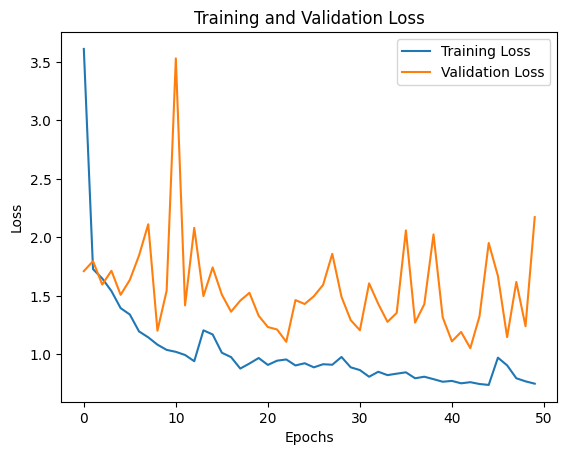

In [56]:
plt.plot(train_loss_hist, label='Training Loss')
plt.plot(val_loss_hist, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

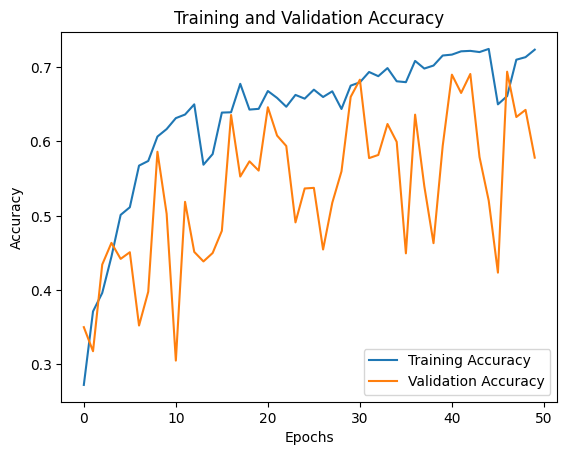

In [57]:
plt.plot(train_acc_hist, label='Training Accuracy')
plt.plot(val_acc_hist, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()